# Installs the geospatial stack (rasterio, GeoPandas, etc.) so wheels are available in your kernel

In [2]:
!pip install rasterio geopandas pyogrio shapely pyproj rtree


  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/7e/1f/56462740694de764fde264051224fcbf800dad43cac92a66753153128866/rasterio-1.4.3-cp311-cp311-win_amd64.whl.metadata
  Using cached rasterio-1.4.3-cp311-cp311-win_amd64.whl.metadata (9.4 kB)
  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/0b/70/d5cd0696eff08e62fdbdebe5b46527facb4e7220eabe0ac6225efab50168/geopandas-1.1.1-py3-none-any.whl.metadata
  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for pyogrio from https://files.pythonhosted.org/packages/74/4e/a5d00c30e5ca3f4133a425fe41531b219139ad4451ea8edc3520f221f9dd/pyogrio-0.11.1-cp311-cp311-win_amd64.whl.metadata
  Using cached pyogrio-0.11.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Obtaining dependency information for shapely from https://files.pythonhosted.org/packages/38/1e/3f8ea46353c2a33c1669eb7327f9665103aa3a8dfe7f2e4ef714c210b2c2/shape

# Imports core libraries (rasterio, matplotlib, numpy, os) for raster I/O and plotting

In [3]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os

##Defines slope_degrees_from_dem() to compute slope (in degrees) from a DEM using pixel spacing and NumPy gradients.

In [4]:
def slope_degrees_from_dem(dem_array, transform):
    # Pixel size (meters) from affine transform
    px_x = transform.a
    px_y = -transform.e  # usually negative

    # Replace nodata with NaN
    dem = dem_array.astype("float64")
    dem[dem == dem.min()]  # (optional) not reliable; better use dem.nodata from raster profile
    # Use profile nodata if available:
    # dem = np.where(dem_array == nodata_val, np.nan, dem_array.astype("float64"))

    # Gradients (dz/dx, dz/dy)
    # np.gradient expects spacing; pass pixel size in meters
    dz_dy, dz_dx = np.gradient(dem, px_y, px_x)  # careful: returns [d/dy, d/dx]

    slope_radians = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    slope_degrees = np.degrees(slope_radians)
    return slope_degrees

Utility + loader block: helpers and logic to open DEM from a folder of tiles or a single file; optional mosaic; quick stats/plots.

Folder detected. Found 909 tif(s). Using the first tile for speed:
E:\waikato_dem_tile.tif\DEM_BC34_2024_1000_4334.tif
(If you want a mosaic of all tiles, set USE_MOSAIC=True below.)
DEM shape: (18, 480)
Elevation (min/max): 19.244 60.36
Slope (min/max): 0.14326974942450327 26.920799348848387


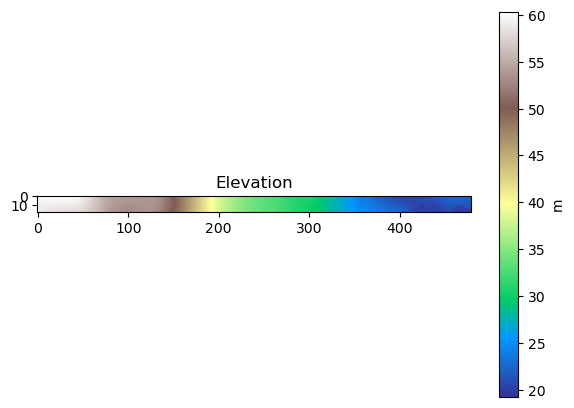

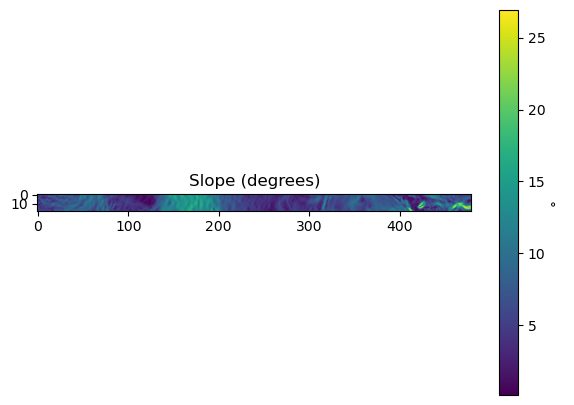

In [8]:
import os, glob, numpy as np, matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge

PATH = r"E:\waikato_dem_tile.tif"  # <-- This is a FOLDER in your case

def slope_degrees_from_dem(dem_array, transform):
    px_x = transform.a
    px_y = -transform.e
    dz_dy, dz_dx = np.gradient(dem_array.astype("float64"), px_y, px_x)
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    return np.degrees(slope_rad)

def open_dem_any(path):
    """Open a DEM either from a single tif file or by mosaicking multiple tiles in a folder."""
    if os.path.isdir(path):
        tifs = sorted(glob.glob(os.path.join(path, "*.tif")))
        if not tifs:
            raise FileNotFoundError(f"No .tif files found inside folder:\n E:\waikato_dem_tile.tif")
        print(f"Folder detected. Found {len(tifs)} tif(s). Using the first tile for speed:\n{tifs[0]}\n"
              f"(If you want a mosaic of all tiles, set USE_MOSAIC=True below.)")
        USE_MOSAIC = False  # set to True to mosaic all tiles

        if USE_MOSAIC:
            srcs = [rasterio.open(p) for p in tifs]
            mosaic, out_transform = merge(srcs)
            profile = srcs[0].profile
            for s in srcs: s.close()
            arr = mosaic[0]
            nodata = profile.get("nodata")
            transform = out_transform
        else:
            with rasterio.open(tifs[0]) as src:
                arr = src.read(1)
                nodata = src.nodata
                transform = src.transform
        return arr, nodata, transform

    else:
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Path does not exist as file: E:\waikato_dem_tile.tif")
        with rasterio.open(path) as src:
            arr = src.read(1)
            nodata = src.nodata
            transform = src.transform
        return arr, nodata, transform

# --- Open DEM ---
arr, nodata, transform = open_dem_any(PATH)

# mask nodata
if nodata is not None:
    arr = np.where(arr == nodata, np.nan, arr)

# compute slope
slope_deg = slope_degrees_from_dem(arr, transform)

print("DEM shape:", arr.shape)
print("Elevation (min/max):", np.nanmin(arr), np.nanmax(arr))
print("Slope (min/max):", np.nanmin(slope_deg), np.nanmax(slope_deg))

# quick plots
plt.figure(figsize=(7,5))
plt.imshow(arr, cmap="terrain")
plt.title("Elevation")
plt.colorbar(label="m")
plt.show()

plt.figure(figsize=(7,5))
plt.imshow(slope_deg)
plt.title("Slope (degrees)")
plt.colorbar(label="°")
plt.show()

Builds a full mosaic from all tiles in your folder with rasterio.merge.merge() and reports shape/transform

In [9]:
import glob, rasterio
from rasterio.merge import merge

tiles = sorted(glob.glob(r"E:\waikato_dem_tile.tif\*.tif"))  # folder holding tiles
srcs = [rasterio.open(p) for p in tiles]
mosaic, out_transform = merge(srcs)   # mosaic[0] is the DEM band
profile = srcs[0].profile
for s in srcs: s.close()

dem = mosaic[0]
nodata = profile.get("nodata")
if nodata is not None:
    dem = np.where(dem == nodata, np.nan, dem)

transform = out_transform
print("Mosaic shape:", dem.shape)

Mosaic shape: (14416, 21596)


Lets you use one tile (already loaded earlier) instead of the full mosaic for speed when exploring.

In [10]:
dem = arr  # use the single tile already loaded
transform = transform

Project “setup” block: defines input/output paths, re-imports common libs, and re-declares the slope helper (ensures clean state)

In [12]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.transform import xy
from rasterio.io import MemoryFile

# ---- INPUT: your tiles folder ----
TILES_DIR = r"E:\waikato_dem_tile.tif"     # (this is a directory of *.tif tiles)
tiles = sorted(glob.glob(os.path.join(TILES_DIR, "*.tif")))
assert tiles, "No TIF tiles found."

# ---- OUTPUTS ----
OUT_DIR = r"E:\CoLab_LiDAR_Demo\outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# slope helper (no richdem needed)
def slope_degrees_from_dem(dem_array, transform):
    px_x = transform.a
    px_y = -transform.e
    dz_dy, dz_dx = np.gradient(dem_array.astype("float64"), px_y, px_x)
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    return np.degrees(slope_rad)

# Mosaic

In [13]:
# Mosaic all tiles (good for a broader AOI)
srcs = [rasterio.open(p) for p in tiles]
mosaic, out_transform = merge(srcs)   # mosaic[0] is DEM
profile = srcs[0].profile
for s in srcs: s.close()

dem = mosaic[0]
nodata = profile.get("nodata")
if nodata is not None:
    dem = np.where(dem == nodata, np.nan, dem)
transform = out_transform

print("Mosaic shape:", dem.shape, "CRS:", profile.get("crs"))

Mosaic shape: (14416, 21596) CRS: EPSG:2193


In [14]:
with rasterio.open(tiles[0]) as src:
    dem = src.read(1).astype("float64")
    transform = src.transform
    nodata = src.nodata
    if nodata is not None:
        dem = np.where(dem == nodata, np.nan, dem)

# Create an AOI rectangle and clip

In [15]:
from shapely.geometry import box
import rasterio.mask

# Choose AOI size (meters); 2500 -> 5 km x 5 km square
half_size_m = 2500  

H, W = dem.shape
cy, cx = H//2, W//2                      # center pixel
Xc, Yc = xy(transform, cy, cx)           # center coords in map units (NZTM)

aoi_geom = [box(Xc-half_size_m, Yc-half_size_m, Xc+half_size_m, Yc+half_size_m)]

# write DEM to memory and clip
profile.update({"height": dem.shape[0], "width": dem.shape[1], "transform": transform, "nodata": nodata})
with MemoryFile() as memfile:
    with memfile.open(**profile) as ds:
        ds.write(dem, 1)
        out_img, out_transform = rasterio.mask.mask(ds, aoi_geom, crop=True, nodata=np.nan)

clipped_dem = out_img[0]
clipped_transform = out_transform

print("Clipped DEM:", clipped_dem.shape)

Clipped DEM: (18, 480)


# Terrain products: slope, hillshade, roughness, curvature

In [16]:
# Slope
slope_deg = slope_degrees_from_dem(clipped_dem, clipped_transform)

# Hillshade (simple Lambertian)
def hillshade(dem_array, transform, azimuth_deg=315, altitude_deg=45):
    az = np.radians(azimuth_deg)
    alt = np.radians(altitude_deg)
    px_x = clipped_transform.a
    px_y = -clipped_transform.e
    dz_dy, dz_dx = np.gradient(dem_array.astype("float64"), px_y, px_x)
    slope = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    aspect = np.arctan2(-dz_dx, dz_dy)
    hs = (np.sin(alt)*np.cos(slope) +
          np.cos(alt)*np.sin(slope)*np.cos(az - aspect))
    return np.clip(hs, 0, 1)

hs = hillshade(clipped_dem, clipped_transform)

# Roughness (local relief): max - min in a 5x5 window
from numpy.lib.stride_tricks import sliding_window_view
def local_range(arr, k=5):
    A = arr.copy()
    A[np.isnan(A)] = -1e9
    w = sliding_window_view(A, (k,k))
    vmin = w.min(axis=(2,3))
    A = arr.copy()
    A[np.isnan(A)] = 1e9
    w = sliding_window_view(A, (k,k))
    vmax = w.max(axis=(2,3))
    # pad back to original shape
    pad = (k//2, k//2)
    out = np.full(arr.shape, np.nan)
    out[pad[0]:-pad[0], pad[1]:-pad[1]] = (vmax - vmin)
    return out

rough5 = local_range(clipped_dem, k=5)

# Curvature (very simple 2nd derivative approx)
def curvature_simple(arr, transform):
    px_x = transform.a
    px_y = -transform.e
    dz_dy, dz_dx = np.gradient(arr.astype("float64"), px_y, px_x)
    d2z_dy2, _ = np.gradient(dz_dy, px_y, px_x)
    _, d2z_dx2 = np.gradient(dz_dx, px_y, px_x)
    return d2z_dx2 + d2z_dy2

curv = curvature_simple(clipped_dem, clipped_transform)

# Visuals for README

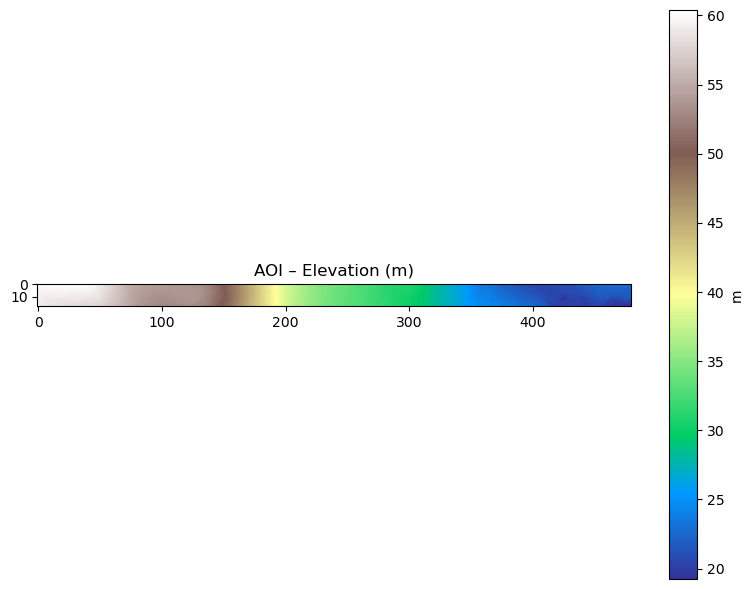

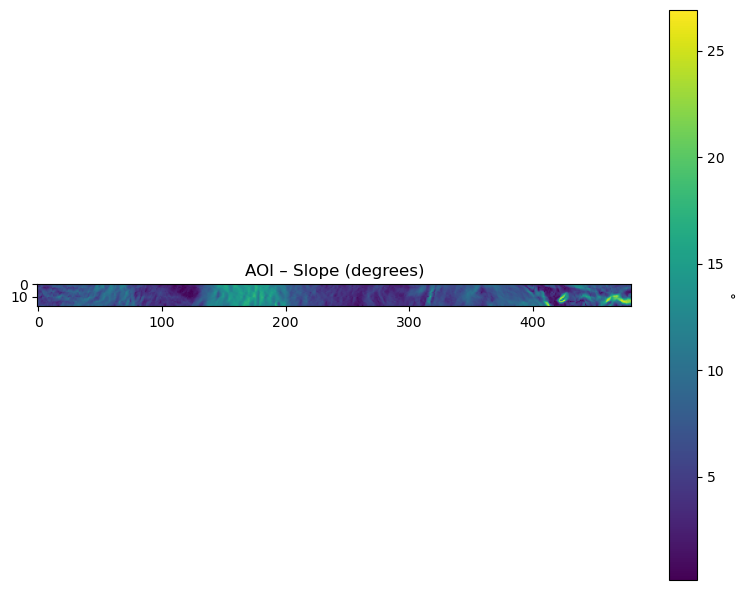

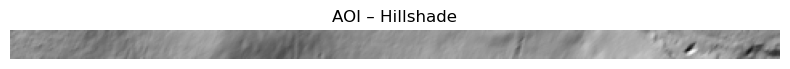

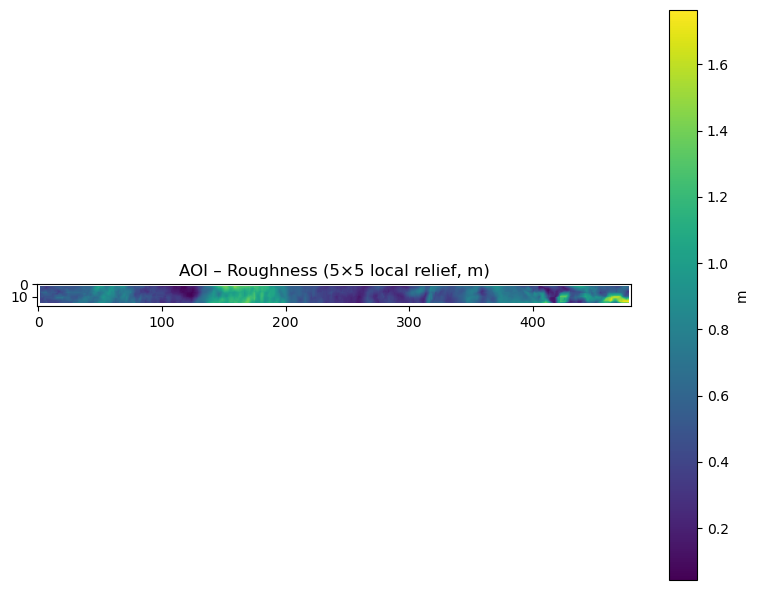

In [17]:
plt.figure(figsize=(8,6))
plt.imshow(clipped_dem, cmap="terrain")
plt.title("AOI – Elevation (m)")
plt.colorbar(label="m"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_elevation.png"), dpi=200)

plt.figure(figsize=(8,6))
plt.imshow(slope_deg)
plt.title("AOI – Slope (degrees)")
plt.colorbar(label="°"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_slope.png"), dpi=200)

plt.figure(figsize=(8,6))
plt.imshow(hs, cmap="gray")
plt.title("AOI – Hillshade"); plt.axis("off"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_hillshade.png"), dpi=200)

plt.figure(figsize=(8,6))
plt.imshow(rough5)
plt.title("AOI – Roughness (5×5 local relief, m)")
plt.colorbar(label="m"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_roughness.png"), dpi=200)

# Hypsometric curve (area vs elevation):

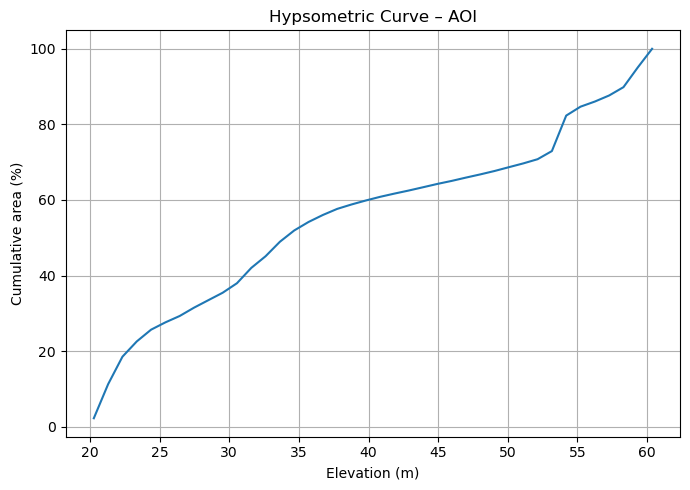

In [18]:
valid = np.isfinite(clipped_dem)
vals = clipped_dem[valid]
hist, edges = np.histogram(vals, bins=40)
cum = np.cumsum(hist)/hist.sum()*100

plt.figure(figsize=(7,5))
plt.plot(edges[1:], cum)
plt.xlabel("Elevation (m)"); plt.ylabel("Cumulative area (%)")
plt.title("Hypsometric Curve – AOI")
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_hypsometric.png"), dpi=200)

# KPIs & slope classes → CSV

In [19]:
def pct(mask): return float(np.nansum(mask))

classes = {"0–5°":(0,5), "5–10°":(5,10), "10–15°":(10,15), "15–20°":(15,20), "20°+":(20, np.inf)}
counts = {k: pct((slope_deg>=lo)&(slope_deg<hi)) for k,(lo,hi) in classes.items()}
total = sum(counts.values()) or 1.0
pixels = np.isfinite(clipped_dem).sum()
pix_area_m2 = 1.0  # 1 m resolution -> 1 m^2 per pixel
area_m2 = pixels * pix_area_m2
area_ha = area_m2 / 10000.0

kpis = {
    "pix_count": int(pixels),
    "area_hectares": round(area_ha,3),
    "elev_min_m": float(np.nanmin(clipped_dem)),
    "elev_mean_m": float(np.nanmean(clipped_dem)),
    "elev_max_m": float(np.nanmax(clipped_dem)),
    "slope_mean_deg": float(np.nanmean(slope_deg)),
    "slope_max_deg": float(np.nanmax(slope_deg)),
    **{f"slope_pct_{k}": round(v/total*100,2) for k,v in counts.items()}
}
pd.DataFrame([kpis]).to_csv(os.path.join(OUT_DIR, "aoi_kpis.csv"), index=False)
kpis

{'pix_count': 8640,
 'area_hectares': 0.864,
 'elev_min_m': 19.243999481201172,
 'elev_mean_m': 37.888755798339844,
 'elev_max_m': 60.36000061035156,
 'slope_mean_deg': 7.198952878664787,
 'slope_max_deg': 26.920799348848387,
 'slope_pct_0–5°': 31.5,
 'slope_pct_5–10°': 49.31,
 'slope_pct_10–15°': 15.36,
 'slope_pct_15–20°': 3.08,
 'slope_pct_20°+': 0.75}

# Grid summary for BI map (mean elev & slope per cell)

In [20]:
from math import ceil
from rasterio.transform import xy
from pyproj import Transformer

bx, by = 50, 50    # grid size in pixels
H, W = clipped_dem.shape
nx, ny = ceil(W/bx), ceil(H/by)

# CRS for lon/lat conversion
dem_crs = profile.get("crs")
transformer = Transformer.from_crs(dem_crs, "EPSG:4326", always_xy=True)

rows = []
for j in range(ny):
    for i in range(nx):
        y0, y1 = j*by, min((j+1)*by, H)
        x0, x1 = i*bx, min((i+1)*bx, W)
        block_dem = clipped_dem[y0:y1, x0:x1]
        block_slope = slope_deg[y0:y1, x0:x1]
        if np.all(~np.isfinite(block_dem)): 
            continue
        mean_elev  = float(np.nanmean(block_dem))
        mean_slope = float(np.nanmean(block_slope))
        cy, cx = (y0+y1)//2, (x0+x1)//2
        X, Y = xy(clipped_transform, cy, cx)
        lon, lat = transformer.transform(X, Y)
        rows.append({
            "cell_i": i, "cell_j": j,
            "mean_elev_m": round(mean_elev,2),
            "mean_slope_deg": round(mean_slope,2),
            "x_nztm": X, "y_nztm": Y,
            "lon": lon, "lat": lat
        })

grid_df = pd.DataFrame(rows)
grid_csv = os.path.join(OUT_DIR, "aoi_grid_summary.csv")
grid_df.to_csv(grid_csv, index=False)
grid_csv

'E:\\CoLab_LiDAR_Demo\\outputs\\aoi_grid_summary.csv'

#  Per-tile QA table (shows “data quality/verification” skills)


In [21]:
tile_stats = []
for p in tiles:
    with rasterio.open(p) as src:
        arr = src.read(1).astype("float64")
        nd = src.nodata
        if nd is not None:
            arr = np.where(arr==nd, np.nan, arr)
        valid = np.isfinite(arr)
        if not valid.any():
            continue
        tile_stats.append({
            "tile": os.path.basename(p),
            "rows": arr.shape[0],
            "cols": arr.shape[1],
            "pct_nodata": round((~valid).sum()/arr.size*100,3),
            "elev_min": float(np.nanmin(arr)),
            "elev_max": float(np.nanmax(arr)),
            "elev_mean": float(np.nanmean(arr))
        })

tiles_df = pd.DataFrame(tile_stats).sort_values("tile")
tiles_csv = os.path.join(OUT_DIR, "tile_quality_summary.csv")
tiles_df.to_csv(tiles_csv, index=False)
tiles_df.head()

,tile,rows,cols,pct_nodata,elev_min,elev_max,elev_mean
0,DEM_BC34_2024_1000_4334.tif,18,480,0.0,19.243999,60.360001,37.888755
1,DEM_BC34_2024_1000_4335.tif,18,480,0.0,14.745000,22.315001,18.691853
2,DEM_BC34_2024_1000_4434.tif,720,480,0.0,18.695000,77.166000,38.045810
3,DEM_BC34_2024_1000_4435.tif,720,480,0.0,9.919000,32.674000,20.235604
4,DEM_BC34_2024_1000_4436.tif,720,480,0.0,4.523000,17.747000,12.602397


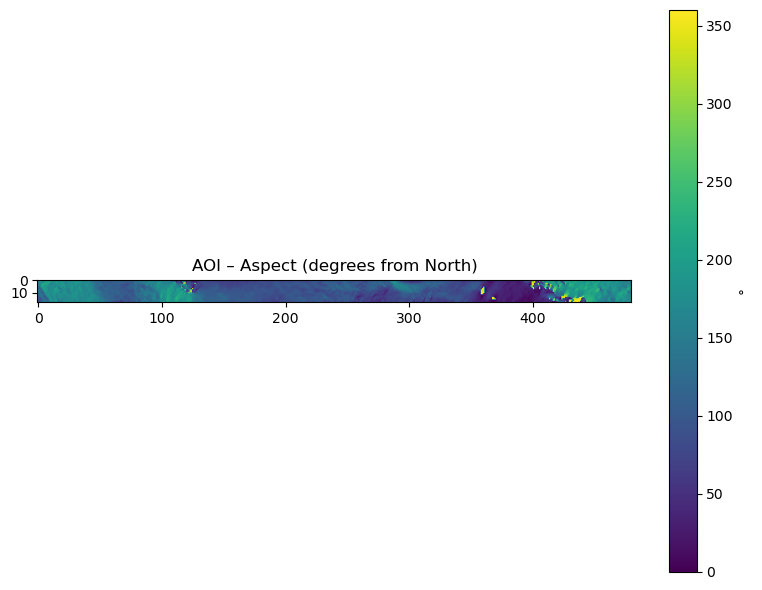

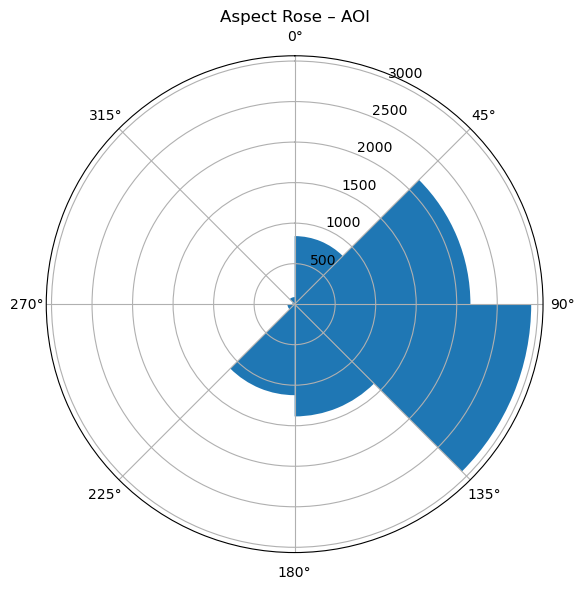

In [23]:
# Aspect map (0–360°; 0/360 = North)
px_x, px_y = clipped_transform.a, -clipped_transform.e
dz_dy, dz_dx = np.gradient(clipped_dem.astype("float64"), px_y, px_x)
aspect = (np.degrees(np.arctan2(-dz_dx, dz_dy)) + 360) % 360
aspect[np.isnan(clipped_dem)] = np.nan

plt.figure(figsize=(8,6))
plt.imshow(aspect, vmin=0, vmax=360)
plt.title("AOI – Aspect (degrees from North)")
plt.colorbar(label="°"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_aspect.png"), dpi=200)

# Aspect rose (8 bins)
bins = np.arange(0, 361, 45)
counts, edges = np.histogram(aspect[np.isfinite(aspect)], bins=bins)
theta = np.deg2rad((edges[:-1] + edges[1:]) / 2)
width = np.deg2rad(np.diff(edges))
ax = plt.figure(figsize=(6,6)).add_subplot(111, projection='polar')
ax.bar(theta, counts, width=width, align='center')
ax.set_theta_zero_location("N"); ax.set_theta_direction(-1)
ax.set_title("Aspect Rose – AOI"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_aspect_rose.png"), dpi=200)

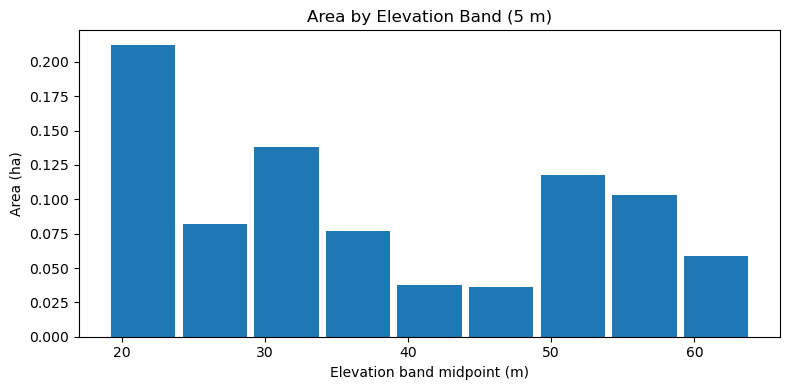

In [24]:
bands = np.arange(np.floor(np.nanmin(clipped_dem)), np.ceil(np.nanmax(clipped_dem))+5, 5)  # 5 m bands
hist, edges = np.histogram(clipped_dem[np.isfinite(clipped_dem)], bins=bands)
area_m2 = hist * 1.0  # 1 m resolution -> 1 m^2 per pixel
elev_tbl = pd.DataFrame({
    "elev_from_m": edges[:-1],
    "elev_to_m": edges[1:],
    "pixel_count": hist,
    "area_m2": area_m2,
    "area_ha": area_m2/10000.0
})
elev_csv = os.path.join(OUT_DIR, "aoi_elevation_bands.csv")
elev_tbl.to_csv(elev_csv, index=False)

plt.figure(figsize=(8,4))
plt.bar((edges[:-1]+edges[1:])/2, elev_tbl["area_ha"], width=4.5)
plt.xlabel("Elevation band midpoint (m)"); plt.ylabel("Area (ha)")
plt.title("Area by Elevation Band (5 m)"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "aoi_elevation_bands.png"), dpi=200)

In [25]:
import json
from shapely.geometry import LineString, mapping

step = 5.0  # contour interval (m)
zmin, zmax = float(np.nanmin(clipped_dem)), float(np.nanmax(clipped_dem))
levels = np.arange(np.floor(zmin/step)*step, np.ceil(zmax/step)*step + step, step)

# simple contour extraction using matplotlib (works well for DEMs)
cs = plt.contour(clipped_dem, levels=levels, linewidths=0.5)
plt.clf()

features = []
for level, seglist in zip(cs.levels, cs.allsegs):
    for seg in seglist:
        # seg is array of row/col coords -> convert to map coords
        rows, cols = seg[:,1], seg[:,0]
        xs, ys = rasterio.transform.xy(clipped_transform, rows, cols)
        geom = LineString(zip(xs, ys))
        features.append({
            "type": "Feature",
            "properties": {"elev_m": float(level)},
            "geometry": mapping(geom)
        })

contours_geojson = os.path.join(OUT_DIR, "aoi_contours_5m.geojson")
with open(contours_geojson, "w", encoding="utf-8") as f:
    json.dump({"type":"FeatureCollection","features":features}, f)
contours_geojson

'E:\\CoLab_LiDAR_Demo\\outputs\\aoi_contours_5m.geojson'

<Figure size 640x480 with 0 Axes>

In [26]:
from rasterio.shutil import copy as rio_copy
from rasterio.enums import Resampling

def write_cog(arr, transform, crs, path):
    prof = {
        "driver": "GTiff",
        "height": arr.shape[0],
        "width": arr.shape[1],
        "count": 1,
        "dtype": "float32",
        "crs": crs,
        "transform": transform,
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512
    }
    tmp = path.replace(".tif", "_tmp.tif")
    with rasterio.open(tmp, "w", **prof) as dst:
        dst.write(arr.astype("float32"), 1)
    rio_copy(tmp, path, copy_src_overviews=True, driver="COG", compress="lzw", BIGTIFF="IF_SAFER")
    os.remove(tmp)

cog_dem = os.path.join(OUT_DIR, "aoi_dem_cog.tif")
cog_slope = os.path.join(OUT_DIR, "aoi_slope_cog.tif")
write_cog(clipped_dem, clipped_transform, profile["crs"], cog_dem)
write_cog(slope_deg, clipped_transform, profile["crs"], cog_slope)
cog_dem, cog_slope

('E:\\CoLab_LiDAR_Demo\\outputs\\aoi_dem_cog.tif',
 'E:\\CoLab_LiDAR_Demo\\outputs\\aoi_slope_cog.tif')

In [29]:
# INLINE FOLIUM MAP (no files saved)
import sys, numpy as np
from IPython.display import display

# 1) Ensure folium is available
try:
    import folium
except ModuleNotFoundError:
    !{sys.executable} -m pip install folium -q
    import folium

from rasterio.transform import array_bounds
from pyproj import Transformer
from matplotlib import cm

# --- assumes you already have: hs, clipped_transform, profile["crs"] ---

# 2) Normalize hillshade [0..1] and convert to uint8 RGBA for Folium
hs_norm = (hs - np.nanmin(hs)) / (np.nanmax(hs) - np.nanmin(hs) + 1e-9)
rgba = (cm.get_cmap("gray")(hs_norm, bytes=True))  # shape (H,W,4), dtype=uint8

# 3) Geographic bounds (lat/lon) for the AOI
miny, minx, maxy, maxx = array_bounds(hs.shape[0], hs.shape[1], clipped_transform)
transformer = Transformer.from_crs(profile["crs"], "EPSG:4326", always_xy=True)
sw_lon, sw_lat = transformer.transform(minx, miny)
ne_lon, ne_lat = transformer.transform(maxx, maxy)

# 4) Build the map and overlay the RGBA image directly (no disk writes)
m = folium.Map(location=[(sw_lat+ne_lat)/2, (sw_lon+ne_lon)/2], zoom_start=13, tiles="CartoDB positron")
folium.raster_layers.ImageOverlay(
    name="Hillshade",
    image=rgba,                                 # numpy array -> in-memory
    bounds=[[sw_lat, sw_lon], [ne_lat, ne_lon]],
    opacity=0.7,
    interactive=False,
    cross_origin=False,
    zindex=1,
).add_to(m)
folium.LayerControl().add_to(m)

# 5) Show inline
display(m)

C:\Users\eshwa\AppData\Local\Temp\ipykernel_65824\2842319665.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rgba = (cm.get_cmap("gray")(hs_norm, bytes=True))  # shape (H,W,4), dtype=uint8
